Car Price Prediction in AWS Sagemaker-XGBoost

In [7]:
import sys
#!{sys.executable} -m pip install xgboost
#!conda install -y -c conda-forge xgboost
#!pip install seaborn

In [8]:
# Import packages

import pandas as pd
import numpy as np
import boto3
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.xgboost import XGBoostModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sagemaker
import sagemaker as seesion
import io
import sagemaker.amazon.common as smac
import os
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3
import urllib.request
import xgboost as xgb

# display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()


In [9]:
# Define the URL and S3 detail
import pandas as pd

# Define the S3 bucket and object key (file path)
bucket = 'car-price-prediction-ug'
data_key = 'datasets/car_price_prediction_raw.csv' # Include any prefixes (folders)

# Construct the full S3 path chanege data lable
data_location = f's3://{bucket}/{data_key}'

# Read the CSV file directly into a pandas DataFrame
df = pd.read_csv(data_location)

# Display the first few rows of the DataFrame
print(df.head())

/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/fsspec/registry.py:301: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


                              name  \
0     2024 Jeep Wagoneer Series II   
1  2024 Jeep Grand Cherokee Laredo   
2         2024 GMC Yukon XL Denali   
3       2023 Dodge Durango Pursuit   
4            2024 RAM 3500 Laramie   

                                         description   make           model  \
0  \n      \n        Heated Leather Seats, Nav Sy...   Jeep        Wagoneer   
1  Al West is committed to offering every custome...   Jeep  Grand Cherokee   
2                                                NaN    GMC        Yukon XL   
3  White Knuckle Clearcoat 2023 Dodge Durango Pur...  Dodge         Durango   
4  \n      \n        2024 Ram 3500 Laramie Billet...    RAM            3500   

   year    price                                             engine  \
0  2024 74600.00                            24V GDI DOHC Twin Turbo   
1  2024 50170.00                                                OHV   
2  2024 96410.00  6.2L V-8 gasoline direct injection, variable v...   
3  2023 4683

In [10]:
df.head()
# Shape of the dataset
df.shape
# Dataset info
df.info()
# Statistical summary
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1002 non-null   object 
 1   description     946 non-null    object 
 2   make            1002 non-null   object 
 3   model           1002 non-null   object 
 4   year            1002 non-null   int64  
 5   price           979 non-null    float64
 6   engine          1000 non-null   object 
 7   cylinders       897 non-null    float64
 8   fuel            995 non-null    object 
 9   mileage         968 non-null    float64
 10  transmission    1000 non-null   object 
 11  trim            1001 non-null   object 
 12  body            999 non-null    object 
 13  doors           995 non-null    float64
 14  exterior_color  997 non-null    object 
 15  interior_color  964 non-null    object 
 16  drivetrain      1002 non-null   object 
dtypes: float64(4), int64(1), object(1

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,1002,358,2023 Dodge Durango Pursuit,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,946,761,\n \n .\n \n,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
make,1002,28,Jeep,194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,1002,153,Hornet,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,1002.00,NaN,NaN,NaN,2023.92,0.30,2023.00,2024.00,2024.00,2024.00,2025.00
price,979.00,NaN,NaN,NaN,50202.99,18700.39,0.00,36600.00,47165.00,58919.50,195895.00
engine,1000,100,16V GDI DOHC Turbo,130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,897.00,NaN,NaN,NaN,4.98,1.39,0.00,4.00,4.00,6.00,8.00
fuel,995,7,Gasoline,664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,968.00,NaN,NaN,NaN,69.03,507.44,0.00,4.00,8.00,13.00,9711.00


In [11]:
# Missing values count and percentage
missing = pd.DataFrame({
    "missing_count": df.isnull().sum(),
    "missing_percent": df.isnull().mean() * 100
})

missing[missing["missing_count"] > 0].sort_values(by="missing_percent", ascending=False)

,missing_count,missing_percent
cylinders,105,10.48
description,56,5.59
interior_color,38,3.79
mileage,34,3.39
price,23,2.30
doors,7,0.70
fuel,7,0.70
exterior_color,5,0.50
body,3,0.30
engine,2,0.20


In [12]:
# Check duplicates
df.duplicated().sum()
#df = df.drop_duplicates()

24

In [13]:
df.dtypes

name               object
description        object
make               object
model              object
year                int64
price             float64
engine             object
cylinders         float64
fuel               object
mileage           float64
transmission       object
trim               object
body               object
doors             float64
exterior_color     object
interior_color     object
drivetrain         object
dtype: object

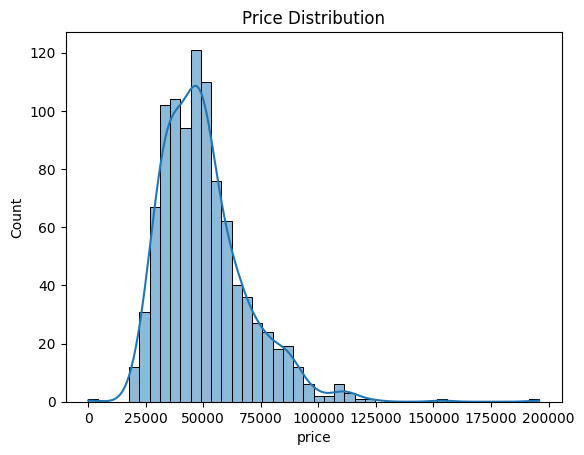

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

#see price distribution
sns.histplot(df["price"], kde=True)
plt.title("Price Distribution")
plt.show()

In [15]:
df["price"].describe()

count      979.00
mean     50202.99
std      18700.39
min          0.00
25%      36600.00
50%      47165.00
75%      58919.50
max     195895.00
Name: price, dtype: float64

In [16]:
# Columns to drop
drop_cols = ["name", "description", "engine"]
df_clean = df.drop(columns=drop_cols)
df_clean.head()

,make,model,year,price,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,Jeep,Wagoneer,2024,74600.00,6.00,Gasoline,10.00,8-Speed Automatic,Series II,SUV,4.00,White,Global Black,Four-wheel Drive
1,Jeep,Grand Cherokee,2024,50170.00,6.00,Gasoline,1.00,8-Speed Automatic,Laredo,SUV,4.00,Metallic,Global Black,Four-wheel Drive
2,GMC,Yukon XL,2024,96410.00,8.00,Gasoline,0.00,Automatic,Denali,SUV,4.00,Summit White,Teak/Light Shale,Four-wheel Drive
3,Dodge,Durango,2023,46835.00,8.00,Gasoline,32.00,8-Speed Automatic,Pursuit,SUV,4.00,White Knuckle Clearcoat,Black,All-wheel Drive
4,RAM,3500,2024,81663.00,6.00,Diesel,10.00,6-Speed Automatic,Laramie,Pickup Truck,4.00,Silver,Black,Four-wheel Drive


In [17]:
# Check shape change
df.shape, df_clean.shape

((1002, 17), (1002, 14))

In [18]:
# Missing values summary
df_clean.isnull().sum()

make                0
model               0
year                0
price              23
cylinders         105
fuel                7
mileage            34
transmission        2
trim                1
body                3
doors               7
exterior_color      5
interior_color     38
drivetrain          0
dtype: int64

In [19]:
# Numerical columns
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns

# Categorical columns
cat_cols = df_clean.select_dtypes(include=["object"]).columns

# Fill missing values
df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())
df_clean[cat_cols] = df_clean[cat_cols].fillna(df_clean[cat_cols].mode().iloc[0])

In [20]:
# Convert to proper numeric types
df_clean["cylinders"] = df_clean["cylinders"].astype(int)
df_clean["doors"] = df_clean["doors"].astype(int)
df_clean["year"] = df_clean["year"].astype(int)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   make            1002 non-null   object 
 1   model           1002 non-null   object 
 2   year            1002 non-null   int64  
 3   price           1002 non-null   float64
 4   cylinders       1002 non-null   int64  
 5   fuel            1002 non-null   object 
 6   mileage         1002 non-null   float64
 7   transmission    1002 non-null   object 
 8   trim            1002 non-null   object 
 9   body            1002 non-null   object 
 10  doors           1002 non-null   int64  
 11  exterior_color  1002 non-null   object 
 12  interior_color  1002 non-null   object 
 13  drivetrain      1002 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 109.7+ KB


In [21]:
df_clean.head()

,make,model,year,price,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,Jeep,Wagoneer,2024,74600.00,6,Gasoline,10.00,8-Speed Automatic,Series II,SUV,4,White,Global Black,Four-wheel Drive
1,Jeep,Grand Cherokee,2024,50170.00,6,Gasoline,1.00,8-Speed Automatic,Laredo,SUV,4,Metallic,Global Black,Four-wheel Drive
2,GMC,Yukon XL,2024,96410.00,8,Gasoline,0.00,Automatic,Denali,SUV,4,Summit White,Teak/Light Shale,Four-wheel Drive
3,Dodge,Durango,2023,46835.00,8,Gasoline,32.00,8-Speed Automatic,Pursuit,SUV,4,White Knuckle Clearcoat,Black,All-wheel Drive
4,RAM,3500,2024,81663.00,6,Diesel,10.00,6-Speed Automatic,Laramie,Pickup Truck,4,Silver,Black,Four-wheel Drive


In [22]:
df_clean["mileage"].describe()

count   1002.00
mean      66.96
std      498.87
min        0.00
25%        4.00
50%        8.00
75%       13.00
max     9711.00
Name: mileage, dtype: float64

In [23]:
# Drop cars with negative mileage if there is 
df_clean = df_clean[df_clean["mileage"] >= 0]

In [24]:
# Price outliers
Q1 = df_clean["price"].quantile(0.25)
Q3 = df_clean["price"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_clean = df_clean[(df_clean["price"] >= lower) & (df_clean["price"] <= upper)]


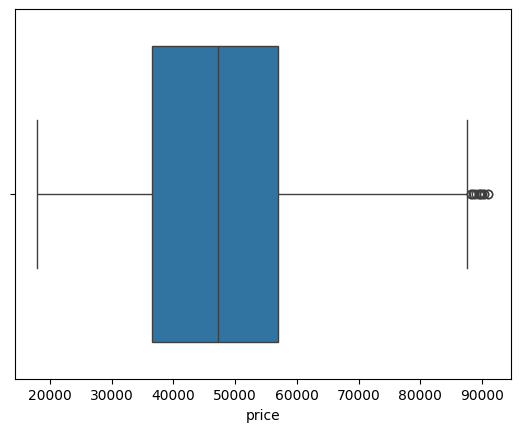

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df_clean["price"])
plt.show()

In [26]:
df = df_clean.copy()
X = df.drop("price", axis=1)
y = df["price"]
df_clean.head()

,make,model,year,price,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,Jeep,Wagoneer,2024,74600.00,6,Gasoline,10.00,8-Speed Automatic,Series II,SUV,4,White,Global Black,Four-wheel Drive
1,Jeep,Grand Cherokee,2024,50170.00,6,Gasoline,1.00,8-Speed Automatic,Laredo,SUV,4,Metallic,Global Black,Four-wheel Drive
3,Dodge,Durango,2023,46835.00,8,Gasoline,32.00,8-Speed Automatic,Pursuit,SUV,4,White Knuckle Clearcoat,Black,All-wheel Drive
4,RAM,3500,2024,81663.00,6,Diesel,10.00,6-Speed Automatic,Laramie,Pickup Truck,4,Silver,Black,Four-wheel Drive
5,Nissan,Murano,2024,46000.00,6,Gasoline,3838.00,Automatic CVT,Platinum,SUV,4,White,Gray,All-wheel Drive


In [27]:
# Encode features
X = pd.get_dummies(X, drop_first=True)

In [28]:
# Ensuring all features are numeric
X = X.astype(float)

In [29]:
# Train–Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import re
# Removes One-hot encoded column names contain characters like [ ] or <, which XGBoost does not allow in DMatrix
X_train.columns = [re.sub(r"[^A-Za-z0-9_]", "_", c) for c in X_train.columns]
X_test.columns  = X_train.columns


In [30]:
# Combine target FIRST, then features
train_df = pd.concat([y, X], axis=1)

# VERY IMPORTANT:
# - No header
# - No index
train_df.to_csv("train_xgb.csv", index=False, header=False)


# Upload to S3
data_location = sess.upload_data(path="train_xgb.csv", bucket=bucket, key_prefix="datasets")

In [31]:
print(f"Check this location in S3: {data_location}")

Check this location in S3: s3://car-price-prediction-ug/datasets/train_xgb.csv


In [32]:
%%writefile train.py  
import argparse
import os
import pandas as pd
import xgboost as xgb

if __name__ == "__main__":
    # SageMaker passes hyperparameters as CLI args
    parser = argparse.ArgumentParser()
    parser.add_argument("--max_depth", type=int)
    parser.add_argument("--eta", type=float)
    parser.add_argument("--subsample", type=float)
    parser.add_argument("--colsample_bytree", type=float)
    parser.add_argument("--objective", type=str)
    parser.add_argument("--eval_metric", type=str)
    parser.add_argument("--num_round", type=int)
    args = parser.parse_args()

    # SageMaker provides training data via this env var
    train_dir = os.environ["SM_CHANNEL_TRAIN"]
    file_name = os.listdir(train_dir)[0]

    # IMPORTANT:
    # - No header
    # - Label is FIRST column
    df = pd.read_csv(os.path.join(train_dir, file_name), header=None)

    y = df.iloc[:, 0]
    X = df.iloc[:, 1:]

    # Use numpy arrays → avoids feature name issues
    dtrain = xgb.DMatrix(X.values, label=y.values)

    params = {
        "max_depth": args.max_depth,
        "eta": args.eta,
        "subsample": args.subsample,
        "colsample_bytree": args.colsample_bytree,
        "objective": args.objective,
        "eval_metric": args.eval_metric
    }

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=args.num_round
    )

    # SageMaker automatically uploads everything in this dir to S3
    model_dir = os.environ["SM_MODEL_DIR"]
    model.save_model(os.path.join(model_dir, "xgboost-model"))

if os.path.exists('train.py'):
    print("SUCCESS: train.py was written to disk.")
else:
    print("ERROR: train.py not found!")

Overwriting train.py


In [33]:
!ls -l

total 4032
-rw-rw-r-- 1 ec2-user ec2-user     763 Feb  7 15:54 app.py
-rw-rw-r-- 1 ec2-user ec2-user   28885 Feb  8 09:47 Car_Price_PredictXGBmodel.ipynb
drwx------ 2 root     root       16384 Jan 25 08:37 lost+found
-rw-rw-r-- 1 ec2-user ec2-user    1670 Feb  8 09:48 train.py
-rw-rw-r-- 1 ec2-user ec2-user 2986901 Feb  8 09:48 train_xgb.csv
-rw-rw-r-- 1 ec2-user ec2-user     787 Jan 25 09:45 Untitled.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 1074719 Jan 25 10:03 Vehicle Price.csv


In [34]:
xgb_estimator = XGBoost(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version="1.7-1",
    hyperparameters={
        "max_depth": 6,
        "eta": 0.05,
        "num_round": 300,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "objective": "reg:squarederror",
        "eval_metric": "rmse"
    }
)

# Train (XGBoost runs in AWS container)
xgb_estimator.fit({"train": data_location})

from sagemaker.xgboost import XGBoost

# Change instance_type from 'ml.m5.xlarge' to 'local'
'''local_estimator = XGBoost(
    entry_point="train.py",
    instance_type="local",  # <--- THIS IS THE MAGIC SWITCH
    role=role,
    framework_version="1.5-1"
)

local_estimator.fit({"train": "file://train.csv"}) # Use 'file://' for local files'''

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2026-02-08-09-48-29-728


2026-02-08 09:48:32 Starting - Starting the training job...
2026-02-08 09:48:47 Starting - Preparing the instances for training...
2026-02-08 09:49:09 Downloading - Downloading input data...
2026-02-08 09:49:49 Downloading - Downloading the training image......
2026-02-08 09:51:00 Training - Training image download completed. Training in progress../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-02-08 09:51:04.490 ip-10-0-235-132.eu-north-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2026-02-08 09:51:04.553 ip-10-0-235-132.eu-north-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2026-02-08:09:51:04:INFO] Imported framework sag

'local_estimator = XGBoost(\n    entry_point="train.py",\n    instance_type="local",  # <--- THIS IS THE MAGIC SWITCH\n    role=role,\n    framework_version="1.5-1"\n)\n\nlocal_estimator.fit({"train": "file://train.csv"}) # Use \'file://\' for local files'

In [35]:
'''#Save modal
model.save_model("xgb_car_price.model")
joblib.dump(X_train.columns.tolist(), "features.pkl")

#upload modal
s3 = boto3.client("s3")

s3.upload_file("xgb_car_price.model", bucket, "car-price/model/xgb_car_price.model")
s3.upload_file("features.pkl", bucket, "car-price/model/features.pkl")'''


'#Save modal\nmodel.save_model("xgb_car_price.model")\njoblib.dump(X_train.columns.tolist(), "features.pkl")\n\n#upload modal\ns3 = boto3.client("s3")\n\ns3.upload_file("xgb_car_price.model", bucket, "car-price/model/xgb_car_price.model")\ns3.upload_file("features.pkl", bucket, "car-price/model/features.pkl")'

In [36]:
model = XGBoostModel( model_data=xgb_estimator.model_data, role=role, framework_version="1.7-1")

In [37]:
# deploy modal
predictor = model.deploy(instance_type="ml.m5.large", initial_instance_count=1)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.large.
INFO:sagemaker:Creating model with name: sagemaker-xgboost-2026-02-08-09-51-47-900
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2026-02-08-09-51-48-495
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2026-02-08-09-51-48-495


------!

In [38]:
predictor.serializer = sagemaker.serializers.CSVSerializer()

In [39]:
# Predict (send numeric features only)

# using one row
'''sample = X_test.iloc[0].copy()

# Convert booleans to 0/1
sample = sample.astype(int)

payload = ",".join(map(str, sample.values))
predictor.predict(payload)'''

# multiple rows
batch = X_test.iloc[:5].copy()
batch = batch.astype(int)

payload = "\n".join(
    ",".join(map(str, row))
    for row in batch.values
)

predictor.predict(payload)

[['79771.34375'],
 ['55903.2734375'],
 ['47055.7890625'],
 ['66558.6484375'],
 ['67188.0703125']]

In [40]:
# Evaluate modal

# Offline evaluation (best)
'''from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(xgb.DMatrix(X_test.values))

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mae, rmse, r2'''


from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Prepare CSV payload (NO label)
payload = "\n".join(
    ",".join(map(str, row))
    for row in X_test.astype(float).values
)

preds = predictor.predict(payload)

# Convert response → float array
y_pred = np.array([float(x[0]) for x in preds])

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2


(2432.4886017628205, 0.9563401589936807)

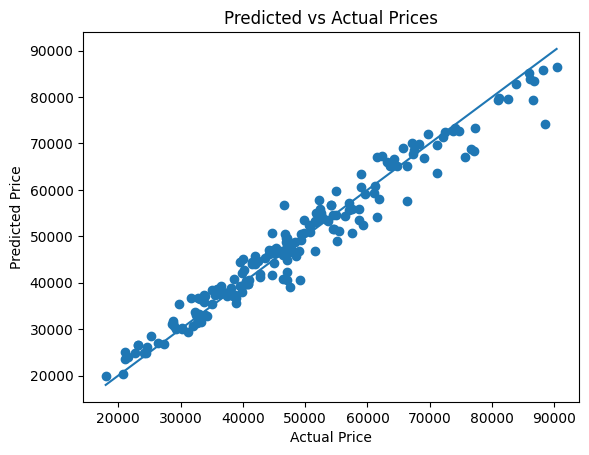

In [41]:
# Ploting predictions vs actual

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.show()


In [42]:
# Delete end point to avoid billing
# predictor.delete_endpoint()

Real World Prediction - Endpoint passed to django project for real world predictaion and recommendation

In [43]:
import boto3

my_region = boto3.session.Session().region_name
print(my_region)

eu-north-1


Django Real World Prediction/Recommendation using Endpoint

In [ ]:
# Urls 
from . import views
from django.contrib import admin
from django.contrib.auth import views as auth_views
from django.urls import path
from django.views.generic.base import RedirectView

app_name='ml'

urlpatterns = [
    path('ml_dashboard', views.ml_dashboard, name="ml_dashboard"),
    path("movies/", views.movies_recommendation_model, name="movies_recommendation_model"),
    path("loan_prediction_model/", views.loan_prediction_model, name="loan_prediction_model"), 
    path("car_prediction_model/", views.predict_price, name="car_prediction_model"),
    path("save-cars/", views.save_car_list, name="save_car_list"),
    path("saved-predictions/", views.saved_predictions, name="saved_predictions"),
]

# Views

from django.shortcuts import render
from django.contrib.auth.decorators import login_required
from .models import CarPrediction
import json
import boto3
import pandas as pd
from io import StringIO

s3 = boto3.client("s3")

bucket = "car-price-prediction-ug"
key = "datasets/car_price_prediction_raw.csv"

obj = s3.get_object(Bucket=bucket, Key=key)

cars_df = pd.read_csv(StringIO(obj["Body"].read().decode("utf-8")))

runtime = boto3.client("sagemaker-runtime", region_name="eu-north-1")

ENDPOINT_NAME = "sagemaker-xgboost-2026-02-08-09-51-48-495"

def predict_price(request):
    prediction = None
    recommendations = None

    if request.method == "POST":

        year = float(request.POST.get("year"))
        mileage = float(request.POST.get("mileage"))
        engine = float(request.POST.get("engine"))
        cylinders = float(request.POST.get("cylinders"))
        doors = float(request.POST.get("doors"))
        drivetrain = float(request.POST.get("drivetrain"))
        fuel = float(request.POST.get("fuel"))              
        transmission = float(request.POST.get("transmission")) 

        values = [year, mileage, engine, cylinders, doors, drivetrain, fuel, transmission]

        payload = ",".join(map(str, values))

        response = runtime.invoke_endpoint(
            EndpointName=ENDPOINT_NAME,
            ContentType="text/csv",
            Body=payload
        )

        prediction = float(response["Body"].read().decode())

        CarPrediction.objects.create(
        year=year,
        mileage=mileage,
        engine=engine,
        cylinders=cylinders,
        doors=doors,
        drivetrain=drivetrain,
        fuel=fuel,
        transmission=transmission,
        predicted_price=prediction
    )

        price_range = 5000

        rec_df = cars_df[
            (cars_df["price"] >= prediction - price_range) &
            (cars_df["price"] <= prediction + price_range)
        ].head(5)

        recommendations = rec_df.to_dict(orient="records")

    return render(request, "car_prediction_model.html", {"prediction": prediction, "recommendations": recommendations})


def save_car_list(request):
    saved = request.session.get("saved_cars", [])
    return render(request, "saved_list.html", {"cars": saved})

def saved_predictions(request):
    predictions = CarPrediction.objects.all().order_by("-created_at")

    return render(request, "saved_list.html", {
        "predictions": predictions
    })


# Models

from django.db import models

class CarPrediction(models.Model):
    year = models.FloatField()
    mileage = models.FloatField()
    engine = models.FloatField()
    cylinders = models.FloatField()
    doors = models.FloatField()
    drivetrain = models.FloatField()
    fuel = models.FloatField()
    transmission = models.FloatField()

    predicted_price = models.FloatField()

    created_at = models.DateTimeField(auto_now_add=True)

    def __str__(self):
        return f"Prediction {self.predicted_price}"

# Html